In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

torch.manual_seed(17)

LABELS = ['bg', 'car']

%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[WindowsPath('data/voc2005_1/Annotations/Caltech_cars'), WindowsPath('data/voc2005_1/Annotations/ETHZ_sideviews-cars'), WindowsPath('data/voc2005_1/Annotations/TUGraz_cars'), WindowsPath('data/voc2005_1/Annotations/UIUC_TestImages'), WindowsPath('data/voc2005_1/Annotations/UIUC_TestImages_Scale')]
BBoxes per scene in int32: 
[[ 47  60 163 169]
 [ 47  49  77  78]
 [105  40 128  61]]

[ 47  60 163 169]
[47 49 77 78]
[105  40 128  61]


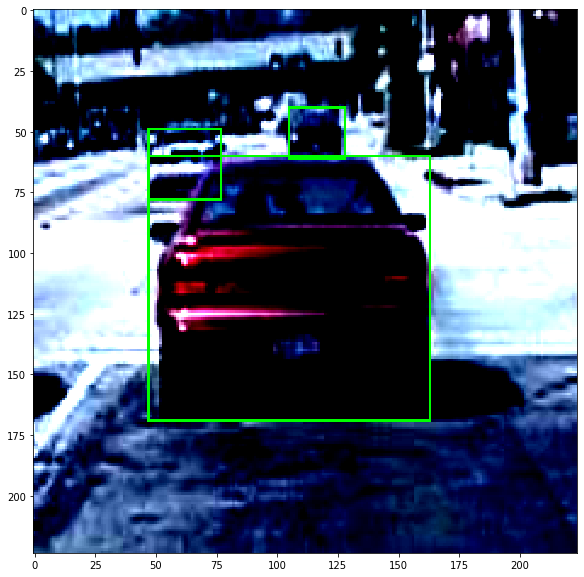

In [2]:
# Pascal VOG: http://host.robots.ox.ac.uk/pascal/VOC/databases.html#VOC2005_1
data_path = Path('data')
root_path = Path('voc2005_1')
annots_path = data_path / root_path / 'Annotations'

class VOCDataset(Dataset):
    def __init__(self, annots_path, label, transforms=None):
        self.annots = []
        valid_paths = []
        self.transforms = transforms
        
        assert(self.transforms is not None)
        
        for dirname in os.listdir(annots_path):
            for filename in os.listdir(annots_path / dirname):
                # read the 1st annot and check if contains 'car'
                with open(annots_path / dirname / filename) as fh:
                    annot = fh.read()
                    if label in annot:
                        valid_paths.append(annots_path / dirname)
                        break
                    
        print(valid_paths)
        
        class Annot:
            def __init__(self, img_path='', idx=-1, img_shape=[], img_label=label, bboxes=None):
                self.img_path = img_path
                self.idx = idx
                self.img_shape = img_shape
                self.img_label = img_label
                self.bboxes = bboxes
            
            def __str__(self):
                return f'{self.img_path}:\n {self.idx} - {self.img_shape} - {self.img_label} - {self.bbox}'
        
        counter = 0
        for path in valid_paths:
            for filename in os.listdir(path):
                with open(path / filename) as fh:
                    img_annot_path = None; bboxes = []; img_annot_shape = None
                    for line in fh:
                        if 'Image filename' in line:
                            img_annot_path = line.split(':')[-1].replace('"', '').replace('\n', '').strip()
                        if 'Bounding box' in line and label in line:
                            bbox_split = ''
                            try:
                                bbox_split = line.split(':')[-1].replace('(', ' ').replace(')', '').replace('-', ',').replace('\n', '').strip().split(',')
                                bbox_split = list(filter(lambda x: x != '' and x != ' ', bbox_split))
                                bboxes.append(np.ascontiguousarray([ int(num.strip()) for num in bbox_split ]).astype(np.float32))
                            except:
                                print(f'Warning: {bbox_split}')
                                continue
                        elif 'Image size' in line:
                            img_annot_shape = [ int(num) for num in line.split(':')[-1].split('x') ]
                    
                    # Add all the boxes per scene
                    bboxes_per_scene = np.zeros((len(bboxes), 4), dtype=np.float32)
                    for idx in range(len(bboxes)):
                        bbox = bboxes[idx]
                        bbox[0] /= img_annot_shape[0]
                        bbox[1] /= img_annot_shape[1]
                        bbox[2] /= img_annot_shape[0]
                        bbox[3] /= img_annot_shape[1]
                        
                        bboxes_per_scene[idx] = np.ascontiguousarray(bbox, dtype=np.float32)
                        
                    self.annots.append(Annot(img_annot_path, counter, img_annot_shape, label, bboxes_per_scene))
                        
                    counter += 1
                    
    def __getitem__(self, index):
        annot = self.annots[index]
        img = Image.open(data_path / annot.img_path)
        bboxes_per_scene = annot.bboxes
        lbl = annot.img_label

        img_tensor = self.transforms(img)
        bboxes_tensor = torch.from_numpy(bboxes_per_scene)

        return img_tensor, bboxes_tensor, int(lbl in LABELS), annot.img_shape

    def __len__(self):
        return len(self.annots)
            
# test
transform_ops = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
trainset = VOCDataset(annots_path, 'car', transform_ops)

img, bboxes, lbl, res = trainset[0]

img = img.cpu().numpy().transpose(1, 2, 0)
bboxes = bboxes.cpu().numpy() * 224
bboxes = bboxes.astype(np.int)
print(f'BBoxes per scene in {bboxes.dtype}: \n{bboxes}\n')

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for bbox in bboxes:
    print(bbox)
    img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [3]:
class FasterRCNN(nn.Module):
    def __init__(self):
        super(FasterRCNN, self).__init__()
        
        self.vgg16 = models.vgg16(pretrained=True).features
        
    def config(self, idx):
        self.vgg16 = self.vgg16[: idx + 1]
        return self

In [4]:
backbone = FasterRCNN().vgg16
#print(backbone)

dummy_img = torch.zeros((1, 3, 800, 800))

counter = 0
out = backbone[0](dummy_img)
print(out.size())
for l in backbone[1:]:
    counter += 1
    out = l(out)
    print(f'{counter} : {out.size()} : {l}')
    
    if out.size(2) <= 800 // 16:
        break
        
backbone = FasterRCNN().config(counter).vgg16
print(backbone(dummy_img).size())

torch.Size([1, 64, 800, 800])
1 : torch.Size([1, 64, 800, 800]) : ReLU(inplace=True)
2 : torch.Size([1, 64, 800, 800]) : Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 : torch.Size([1, 64, 800, 800]) : ReLU(inplace=True)
4 : torch.Size([1, 64, 400, 400]) : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 : torch.Size([1, 128, 400, 400]) : Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 : torch.Size([1, 128, 400, 400]) : ReLU(inplace=True)
7 : torch.Size([1, 128, 400, 400]) : Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 : torch.Size([1, 128, 400, 400]) : ReLU(inplace=True)
9 : torch.Size([1, 128, 200, 200]) : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 : torch.Size([1, 256, 200, 200]) : Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 : torch.Size([1, 256, 200, 200]) : ReLU(inplace=True)
12 : torch.Size([1, 256, 200, 200]) : Conv2d(256, 2

Anchors:
[[317.49033201 362.745166   498.50966799 453.254834  ]
 [344.         344.         472.         472.        ]
 [362.745166   317.49033201 453.254834   498.50966799]
 [226.98066402 317.49033201 589.01933598 498.50966799]
 [280.         280.         536.         536.        ]
 [317.49033201 226.98066402 498.50966799 589.01933598]
 [ 45.96132803 226.98066402 770.03867197 589.01933598]
 [152.         152.         664.         664.        ]
 [226.98066402  45.96132803 589.01933598 770.03867197]]

Number of locations: 2500



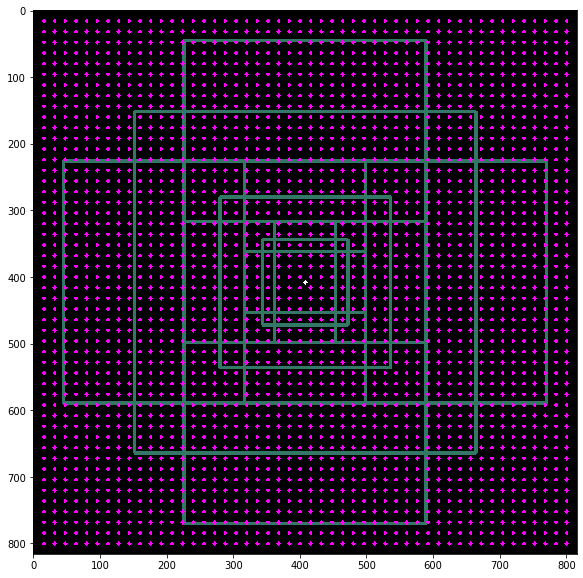

In [5]:
scales = [ 8, 16, 32 ] # how small relative to the size of input image
ratios = [ 0.5, 1.0, 2.0 ] # ratio of w/h

# generate anchor boxes at the representation @ torch.Size([1, 512, 50, 50])
# the representation is 16 times smaller -> 1pxl <=> 16 pxls (original 800x800 image)
'''
    At each feature map's location (50 x 50), we create 9 anchor boxes with x1, y1, x2, y2 => shape=[9, 4]
'''
subsample = 16 # by this amount we downscale the input image
anchors = np.zeros(shape=(9, 4))

# per location of 1 px (equivalent to 16 pxls in original)
row = col = 25
cx = subsample / 2 + col * subsample
cy = subsample / 2 + row * subsample

for i in range(len(scales)):
    scale = scales[i]
    
    for j in range(len(ratios)):
        ratio = ratios[j]
        
        # We bring it to actual image size by * subsample_size
        side = subsample * scale
        h = side * np.sqrt(ratio) / 2
        w = side * np.sqrt(1.0 / ratio) / 2
        
        tl_x = cx - w
        tl_y = cy - h
        br_x = cx + w
        br_y = cy + h
        
        anchors[i * len(scales) + j] = np.array([ tl_x, tl_y, br_x, br_y ])
        
print(f'Anchors:\n{anchors}\n')

sample_img = np.zeros(shape=(816, 816, 3)).astype(np.uint8); counter = 1
bgr = np.array([50, 120, 100]).astype(np.int)
for anchor in anchors:
    sample_img = cv2.circle(sample_img, (int(cx), int(cy)), 1, (255, 255, 255), 3)
    #if counter != 3 and counter % 3 == 0:
    #    random_n = np.random.randint(-100, 100)
    #    bgr += random_n
    #    bgr = np.clip(bgr, 0, 255).astype(np.int)
    b, g, r = bgr
    #print(bgr)
    sample_img = cv2.rectangle(sample_img, (int(anchor[0]), int(anchor[1])), (int(anchor[2]), int(anchor[3])), (int(b), int(g), int(r)), 3)
    counter += 1
    
rows = cols = 800 // 16; nlocs = 0
for row in range(1, rows + 1):
    for col in range(1, cols + 1):
        sample_img = cv2.circle(sample_img, (row * 16, col * 16), 1, (255, 0, 255), 3)
        nlocs += 1
        
print(f'Number of locations: {nlocs}\n')
    
#plt.xlim(-300, 300)
#plt.ylim(-300, 300)
plt.figure(figsize=(10, 10))
plt.imshow(sample_img)

In [6]:
# generate anchor boxes at each location
def generate_anchor(row, col, subsample_size, scales, ratios):
    nscales = len(scales)
    nratios = len(ratios)
    
    anchor_bboxes = np.zeros(shape=(nscales * nratios, 4)).astype(np.float32)
    
    cx = subsample / 2 + col * subsample
    cy = subsample / 2 + row * subsample

    for i in range(nscales):
        scale = scales[i]
        for j in range(nratios):
            ratio = ratios[j]
            
            side = subsample * scale
            h = side * np.sqrt(ratio) / 2
            w = side * np.sqrt(1.0 / ratio) / 2

            tl_x = cx - w
            tl_y = cy - h
            br_x = cx + w
            br_y = cy + h

            anchor_bboxes[i * nscales + j] = np.array([ tl_x, tl_y, br_x, br_y ])
            
    return anchor_bboxes

input_img_size = 800
subsample_size = 16

def generate_anchors(input_img_size, subsample_size, scales, ratios):
    location_anchors = []
    rows = cols = input_img_size // subsample_size
    for row in range(rows):
        for col in range(cols):
            location_anchors.append(generate_anchor(row, col, subsample_size, scales, ratios))
    return np.ascontiguousarray(location_anchors).astype(np.float32)

location_anchors = generate_anchors(input_img_size, subsample_size, scales, ratios)

print(f'before @ {hex(id(location_anchors))}: {location_anchors.shape}\n')
location_anchors = location_anchors.reshape((-1, 4))
print(f'after @ {hex(id(location_anchors))}: {location_anchors.shape}\n')

size = input_img_size // subsample
center = int(0.5 * size * (size + 1)) * 9
print(location_anchors[center : center + 9])

before @ 0x2cc09a291c0: (2500, 9, 4)

after @ 0x2cc08e09800: (22500, 4)

[[317.49033  362.74518  498.50967  453.25482 ]
 [344.       344.       472.       472.      ]
 [362.74518  317.49033  453.25482  498.50967 ]
 [226.98067  317.49033  589.01935  498.50967 ]
 [280.       280.       536.       536.      ]
 [317.49033  226.98067  498.50967  589.01935 ]
 [ 45.961327 226.98067  770.0387   589.01935 ]
 [152.       152.       664.       664.      ]
 [226.98067   45.961327 589.01935  770.0387  ]]


[[317.49033  362.74518  498.50967  453.25482 ]
 [344.       344.       472.       472.      ]
 [362.74518  317.49033  453.25482  498.50967 ]
 [226.98067  317.49033  589.01935  498.50967 ]
 [280.       280.       536.       536.      ]
 [317.49033  226.98067  498.50967  589.01935 ]
 [ 45.961327 226.98067  770.0387   589.01935 ]
 [152.       152.       664.       664.      ]
 [226.98067   45.961327 589.01935  770.0387  ]]
Number of locations: 2500



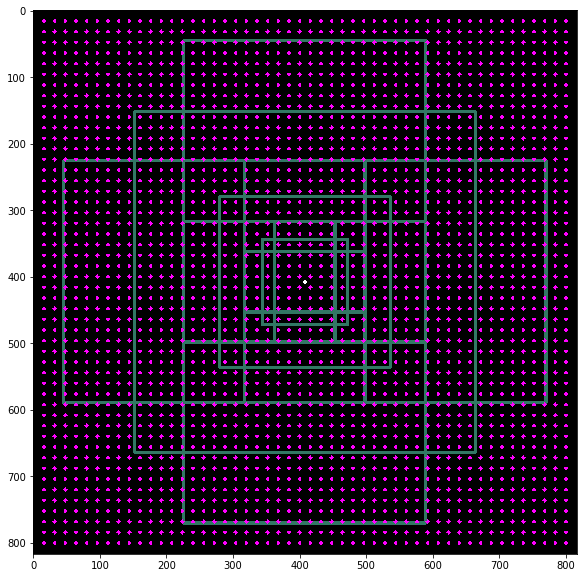

In [7]:
# test if correct
def visualize_anchors_for_location(anchors, input_img_size, subsample_size, sample_img=None):
    if sample_img is None:
        sample_img = np.zeros(shape=(input_img_size + subsample_size + 1, input_img_size + subsample_size + 1, 3)).astype(np.uint8)
    counter = 1
    for anchor in anchors:
        sample_img = cv2.circle(sample_img, (int(cx), int(cy)), 1, (255, 255, 255), 3)
        sample_img = cv2.rectangle(sample_img, (int(anchor[0]), int(anchor[1])), (int(anchor[2]), int(anchor[3])), (50, 120, 100), 3)
        counter += 1

    rows = cols = input_img_size // subsample_size; nlocs = 0
    for row in range(1, rows + 1):
        for col in range(1, cols + 1):
            sample_img = cv2.circle(sample_img, (row * subsample_size, col * subsample_size), 1, (255, 0, 255), 3)
            nlocs += 1

    print(f'Number of locations: {nlocs}\n')

    plt.figure(figsize=(10, 10))
    plt.imshow(sample_img)
    
center_idx = int(0.5 * size * (size + 1)) * 9 # midpoint: (25 * 50 + 25) * 9 = (row * cols + col) * scale
print(location_anchors[center_idx : center_idx + 9])
visualize_anchors_for_location(location_anchors[center_idx : center_idx + 9], input_img_size, subsample_size)

In [8]:
def IoU(bbox1, bbox2, eps=1e-15):
    #print(f'{bbox1} - {bbox2}')
    
    '''
        max x: from the left to right
        min x: from the right to left
        max y: from the top down
        min y: from the bottom up
        
        [left_x, top_y, right_x, bottom_y] - [0, 1, 2, 3]
    '''
    bbox1[bbox1 < 0] = 0
    bbox2[bbox2 < 0] = 0
    
    min_x = min(bbox1[2], bbox2[2])
    min_y = min(bbox1[3], bbox2[3])
    max_x = max(bbox1[0], bbox2[0])
    max_y = max(bbox1[1], bbox2[1])
    
    #print(f'{max_x}, {min_x}, {max_y}, {min_y}')
    
    intersection = max(0, min_x - max_x) * max(0, min_y - max_y)
    area1 = max(0, bbox1[2] - bbox1[0]) * max(0, bbox1[3] - bbox1[1])
    area2 = max(0, bbox2[2] - bbox2[0]) * max(0, bbox2[3] - bbox2[1])
    union = area1 + area2 - intersection
    
    return intersection / float(union + eps) # numerical stability

bboxes = np.ascontiguousarray([
    [39, 63, 203, 112],
    [54, 66, 198, 114],
    [49, 75, 203, 125], 
    [42, 78, 186, 126],
    [31, 69, 201, 125], 
    [18, 63, 235, 135],
    [50, 72, 197, 121], 
    [54, 72, 198, 120],
    [35, 51, 196, 110], 
    [36, 60, 180, 108]
]).astype(np.float32)

ios_true = np.ascontiguousarray([ 0.7980, 0.7899, 0.6125, 0.9472, 0.7310 ]).astype(np.float32)

ios_computed = np.ascontiguousarray([ IoU(bbox1, bbox2) for (bbox1, bbox2) in zip(bboxes[0::2], bboxes[1::2]) ]).astype(np.float32)

print(ios_true)
print(ios_computed)

err = np.mean(np.sqrt(np.square(np.round(ios_computed, 3) - np.round(ios_true, 3)))) * 100
print(err)

[0.798  0.7899 0.6125 0.9472 0.731 ]
[0.79577124 0.787838   0.609319   0.94662803 0.72765553]
0.19999979995191097


In [9]:
'''
    We need to have, at the end:
    anchor_locations [N, 4] — [22500, 4]
    anchor_labels [N,] — [22500]
    
    Build the anchor labels: 
    (A) highest IoU(anchor, gt_bbox) or IoU(anchor, gt_bbox) > 0.7 get assigned +1
    (B) IoU(anchor, gt_bbox) < 0.3, get assigned -1
    (C) the rest is not used in training the RPN
'''

'\n    We need to have, at the end:\n    anchor_locations [N, 4] — [22500, 4]\n    anchor_labels [N,] — [22500]\n    \n    Build the anchor labels: \n    (A) highest IoU(anchor, gt_bbox) or IoU(anchor, gt_bbox) > 0.7 get assigned +1\n    (B) IoU(anchor, gt_bbox) < 0.3, get assigned -1\n    (C) the rest is not used in training the RPN\n'

[WindowsPath('data/voc2005_1/Annotations/Caltech_cars'), WindowsPath('data/voc2005_1/Annotations/ETHZ_sideviews-cars'), WindowsPath('data/voc2005_1/Annotations/TUGraz_cars'), WindowsPath('data/voc2005_1/Annotations/UIUC_TestImages'), WindowsPath('data/voc2005_1/Annotations/UIUC_TestImages_Scale')]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of overlaps:  1
Number of locations: 9



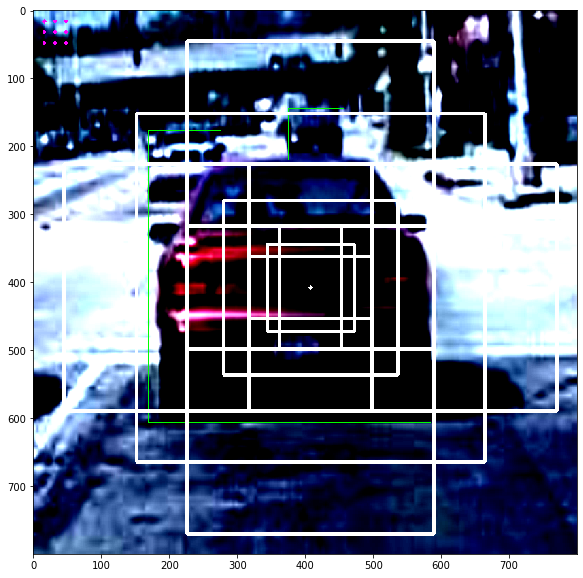

In [15]:
# Sample annotions
img_size = 800

transform_ops = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
trainset = VOCDataset(annots_path, 'car', transform_ops)

img, bboxes, lbl, res = trainset[0]

img = img.cpu().numpy().transpose(1, 2, 0)
bboxes = bboxes.cpu().numpy() * img_size
bboxes = bboxes.astype(np.int)
#print(f'BBoxes per scene in {bboxes.dtype}: \n{bboxes}\n')

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for bbox in bboxes:
    img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

anchors = generate_anchors(input_img_size=800, subsample_size=16, scales=[8, 16, 32], ratios=[0.5, 1.0, 2.0]).reshape(-1, 4)

#print(bboxes.shape)
#print(anchors.shape)

# Label the anchors
anchor_labels = np.zeros(shape=(anchors.shape[0]))
anchor_labels.fill(-1)
#print(anchor_labels.shape)
#print(anchor_labels[:3])

def label_anchors(gt_bboxes, anchor_bboxes, labels):
    iou_values = []
    for idx in range(anchor_bboxes.shape[0]):
        anchor_bbox = anchor_bboxes[idx]
        for gt_bbox in gt_bboxes:
            iou_values.append(IoU(anchor_bbox, gt_bbox))
            if iou_values[-1] >= 0.7:
                print(iou_values[-1])
                labels[idx] = 1
    
    max_iou_idx = np.argmax(iou_values)
    if iou_values[max_iou_idx] > 0.3:
        labels[max_iou_idx] = 1
    
    return labels

anchor_labels = label_anchors(bboxes, anchors, anchor_labels)
print('Number of overlaps: ', len(anchor_labels[anchor_labels == 1]))

size = img_size // 16
center_idx = int(0.5 * size * (size + 1)) * 9
visualize_anchors_for_location(anchors[center_idx : center_idx + 9], size, 16, img)
plt.imshow(img)
plt.show()